In [1]:
from IPython.display import Image
from PIL import Image

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from torchvision import transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

import tqdm
import os

In [2]:
torch.cuda.is_available()

True

In [3]:
import zipfile
from google.colab import drive

In [4]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
!ls 'drive/MyDrive/data/dataset'

proliv	test_proliv  train_proliv


In [6]:
#!unzip 'drive/My Drive/dataset.zip' -d 'drive/MyDrive/data'

In [7]:
device = 'cuda'

In [8]:

from lightning import seed_everything
seed_everything(seed=42, workers=True)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


42

In [9]:
folder_path = "drive/MyDrive/data/dataset/train_proliv"

width_arr = 0
height_arr = 0
count_img = 0

for file in os.listdir(folder_path):
    if file.endswith(('.png', '.jpg', '.jpeg', '.gif')):
        image_path = os.path.join(folder_path, file)
        with Image.open(image_path) as img:
            width, height = img.size
            width_arr += width
            height_arr += height
            count_img += 1

w = width_arr / count_img
h = height_arr / count_img
print(f"Средняя ширина {w} пикселей")
print(f"Средняя высота {h} пикселей")

w = int(w * 0.7)
h = int(h * 1)


Средняя ширина 48.2663 пикселей
Средняя высота 27.2345 пикселей


границы с левой и правой стороны не несут полезной информации. Округляю до width_resize = 33, height_resize = 28. Далее на изображениях посмотрим на случайных примерах, так ли это.

In [10]:
width_resize = 33
height_resize = 27

In [11]:
#ls 'drive/MyDrive/data/dataset/test_proliv/imgs'

Пример рандомного тренировочного изображения

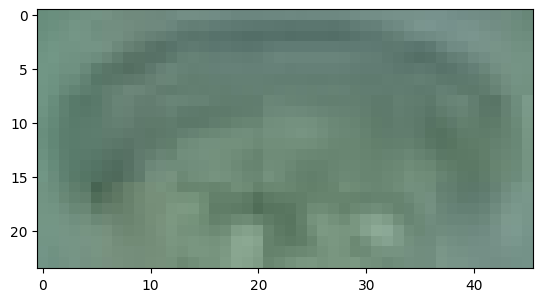

In [12]:
from matplotlib.pyplot import imshow
%matplotlib inline
pil_im = Image.open('drive/MyDrive/data/dataset/train_proliv/8b639c44-7d0a-412a-b2a4-fb4344e4a0fe.jpg', 'r')
imshow(np.asarray(pil_im))

Пример рандомного тестового изображения

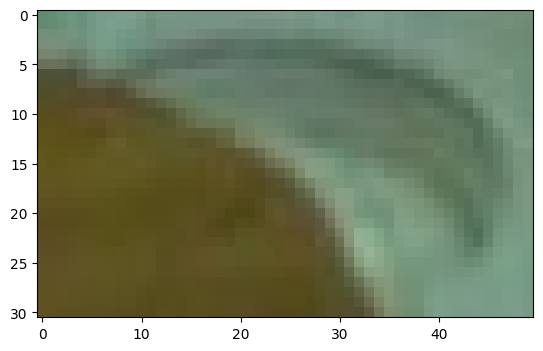

In [13]:
pil_im = Image.open('drive/MyDrive/data/dataset/test_proliv/imgs/f1d1856e-19ba-45e1-b771-9670d2f48be5.jpg', 'r')
imshow(np.asarray(pil_im))

попробовал несколько разных аугментаций - спойлер: первая чуть лучше по кач-ву, но со второй быстрее. Подумаю, как их "смешать"

In [14]:
from torch.utils.data import Dataset as TorchDataset
class Dataset_prep_1(TorchDataset):
    mean = (0.4237, 0.5344, 0.4620)
    std = (0.0472, 0.0526, 0.0489)
    resize_height = 32
    resize_width = 48
    crop_height = 32
    crop_width = 32

    def get_sorted_file_paths(dir_path):
        return sorted((path for path in dir_path.iterdir() if path.is_file()), key=lambda path: path.name)

    def __init__(self, dataset_dir, variant):
        self.variant = variant
        if self.variant == 'train':
            self.image_paths = self.get_sorted_file_paths(dataset_dir / 'train_proliv')
        elif self.variant == 'anomaly':
            self.image_paths = self.get_sorted_file_paths(dataset_dir / 'proliv')
        elif self.variant == 'test':
            self.image_paths = []
            self.image_labels = []
            with open(dataset_dir / 'test' / 'test_annotation.txt', 'r') as ann_file:
                for ann in ann_file.readlines():
                    file_name, label = ann.split()
                    self.image_paths.append(dataset_dir / 'test_proliv' / 'imgs' / file_name)
                    self.image_labels.append(int(label))

        self.train_transforms = albumentations.Compose([
            albumentations.Resize(height=self.resize_height, width=self.resize_width),
            albumentations.CenterCrop(height=self.crop_height, width=self.crop_width),
            albumentations.HorizontalFlip(),
            albumentations.VerticalFlip(),
            albumentations.RandomBrightnessContrast(),
            albumentations.Normalize(mean=self.mean, std=self.std),
            ToTensorV2()
        ])

        self.transforms = albumentations.Compose([
            albumentations.Resize(height=self.resize_height, width=self.resize_width),
            albumentations.CenterCrop(height=self.crop_height, width=self.crop_width),
            albumentations.Normalize(mean=self.mean, std=self.std),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        pil_image = Image.open(self.image_paths[index]).convert('RGB')

        if self.variant == 'train':
            transforms = self.train_transforms
        else:
            transforms = self.transforms

        transformed_image = transforms(image=np.array(pil_image))['image']

        if self.variant != 'test':
            return transformed_image
        return transformed_image, self.image_labels[index]

Вторая итерация аугментаций

In [15]:
class Dataset_prep_2(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_list = os.listdir(root_dir)

        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((height_resize, width_resize)),
            transforms.GaussianBlur(7, 0.5),
            transforms.ToTensor(),
        ])
    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_list[idx])
        image = Image.open(img_name).convert("RGB")

        new_width = int(image.width * 0.7)
        left = int((image.width - new_width) / 2)
        right = left + new_width
        image = image.crop((left, 0, right, image.height))

        blue_channel = image.split()[0]
        gray_blue_channel = blue_channel.convert("L")
        image = self.transform(gray_blue_channel)

        return image, img_name

Энкодер

In [16]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(height_resize * width_resize, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, height_resize * width_resize)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, height_resize, width_resize))

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

def train(autoencoder, data, epochs=30):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm.tqdm(range(epochs)):
        for img, img_name in data:
            x = img.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

latent_dims = 2
autoencoder = VariationalAutoencoder(latent_dims).to(device)

In [17]:
train_data_path = "drive/MyDrive/data/dataset/train_proliv"
train_dataset = Dataset_prep_2(root_dir=train_data_path)
train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=10000,
        shuffle=True)

In [18]:
model_2nd_prep = train(autoencoder, train_dataloader, epochs=40).to(device)
model_2nd_prep.eval()

100%|██████████| 40/40 [14:42<00:00, 22.07s/it]


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=891, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=2, bias=True)
    (linear3): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=891, bias=True)
  )
)

Посмотрим на преобразованные изображения

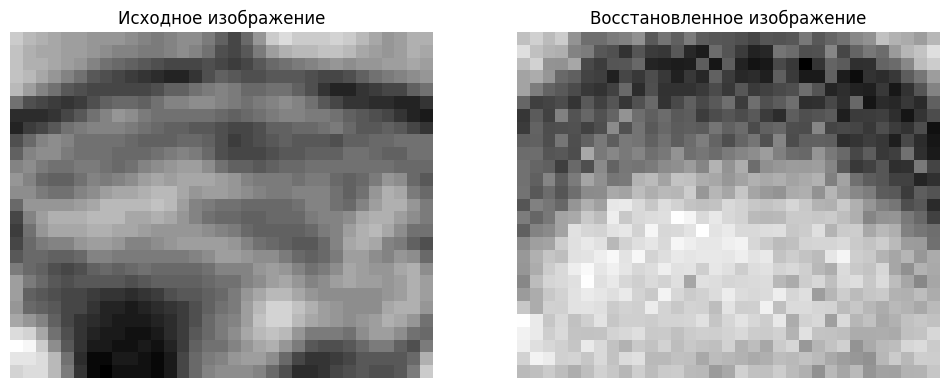

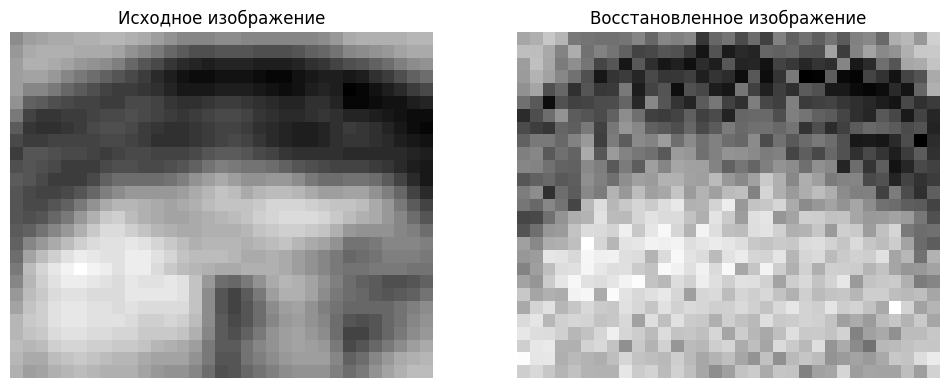

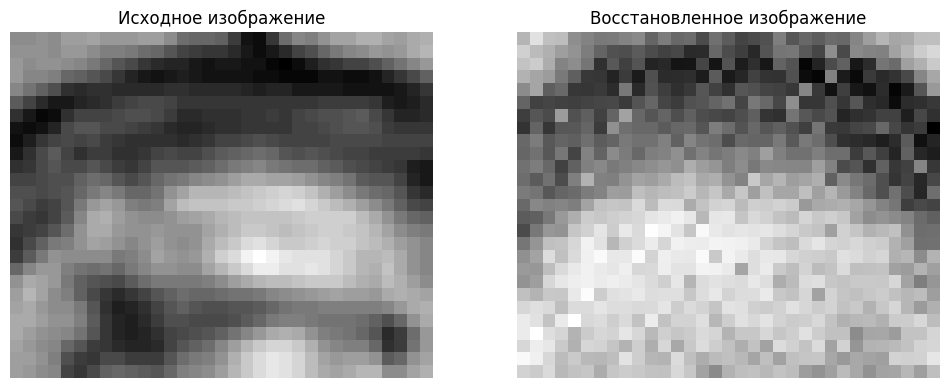

In [81]:

with torch.no_grad():
    for img, img_name in train_dataloader:
        original_imgs = img.to(device)

        restored_imgs = model_2nd_prep(original_imgs)


        for i in range(3):
            plt.figure(figsize=(12, 6))

            #здесь исходники
            plt.subplot(1, 2, 1)
            plt.imshow(original_imgs[i][0].cpu().numpy(), cmap='gray')
            plt.title('Исходное изображение')
            plt.axis('off')



            #здесь восстановленные
            plt.subplot(1, 2, 2)
            plt.imshow(restored_imgs[i][0].cpu().numpy(), cmap='gray')
            plt.title('Восстановленное изображение')
            plt.axis('off')

            plt.show()

        break

Согласно предложенного плана решения, нужно выбрать вручную пороговое значение MSE. Кажется, что также надо обратить внимание на изображения с объектами, которые загорожены иным предметом

In [20]:
def mse_impl(image1, image2):
    mse_calc = F.mse_loss(image1, image2, reduction='mean')
    return mse_calc.item()

In [22]:
images_mse_arr = []

with torch.no_grad():
    for img, img_name in train_dataloader:
        original_imgs = img.to(device)
        restored_imgs = model_2nd_prep(original_imgs)

        for i in range(len(original_imgs)):
            images_mse_arr.append(mse_impl(original_imgs[i], restored_imgs[i]))

In [64]:
mse_anomaly = max(images_mse_arr) * 0.22
mse_remove = max(images_mse_arr) * 0.9

In [65]:
print(mse_anomaly)
print(mse_remove)

0.0033691088296473027
0.013629576629027725


In [66]:
class TestTransform(Dataset):
    def __init__(self, root_dir, annotation_file):
        self.images_dir = os.path.join(root_dir, "imgs")
        self.annotations = pd.read_csv(os.path.join(root_dir, annotation_file), delimiter=' ', header=None, names=['filename', 'label'])
        self.image_list = os.listdir(self.images_dir)

        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((height_resize, width_resize)),
            transforms.GaussianBlur(7, 0.5),
            transforms.ToTensor(),
        ])
    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.image_list[idx])
        image = Image.open(img_name).convert("RGB")

        new_width = int(image.width * 0.7)
        left = int((image.width - new_width) / 2)
        right = left + new_width
        image = image.crop((left, 0, right, image.height))

        blue_channel = image.split()[0]
        gray_blue_channel = blue_channel.convert("L")
        image = self.transform(gray_blue_channel)

        label = self.annotations[self.annotations["filename"].isin([self.image_list[idx]])]["label"].iloc[0]
        return image, img_name, label

In [67]:
test_data_path = "drive/MyDrive/data/dataset/test_proliv"
annotation_file = "test_annotation.txt"
test_dataset = TestTransform(root_dir=test_data_path, annotation_file=annotation_file)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000)

In [68]:
imgs_mse_anom = []
imgs_mse_norm = []

with torch.no_grad():
    for img, img_name, labels in test_dataloader:
        original_images = img.to(device)
        reconstructed_images = model_2nd_prep(original_images)

        for i in range(len(original_images)):
            mse = mse_impl(original_images[i], reconstructed_images[i])

            if (labels[i] == 1):
                imgs_mse_anom.append(mse)
            else:
                 imgs_mse_norm.append(mse)

In [69]:
#!ls "drive/MyDrive/data/dataset/test_proliv"

In [70]:
labels_tar = []
labels_pred = []

with torch.no_grad():
    for img, img_name, label in test_dataloader:
        original_images = img.to(device)
        reconstructed_images = model_2nd_prep(original_images)

        for i in range(len(original_images)):
            mse = mse_impl(original_images[i], reconstructed_images[i])

            if (mse > mse_anomaly and mse < mse_remove):
                label_pred = 1
            else:
                label_pred = 0


            labels_tar.append(label[i])
            labels_pred.append(label_pred)

In [80]:
labels_tar = torch.tensor(labels_tar)
labels_pred = torch.tensor(labels_pred)

TP = torch.sum((labels_pred == 1) & (labels_tar == 1)).item()
TN = torch.sum((labels_pred == 0) & (labels_tar == 0)).item()
FP = torch.sum((labels_pred == 1) & (labels_tar == 0)).item()
FN = torch.sum((labels_pred == 0) & (labels_tar == 1)).item()

TPR = TP / (TP + FN)
TNR = TN / (TN + FP)

print("True Positive Rate (TPR):", TPR)
print("True Negative Rate (TNR):", TNR)

True Positive Rate (TPR): 0.9213934804898576
True Negative Rate (TNR): 0.9115961800818554
